# Performance-recall graph

Most classification methods score each datapoint and binary classification is achieved by thresholding -- all datapoints with scores below the threshold are labelled as negatives and all datapoints with scores above the threshold are labelled as positives. 
Note that there is no magic formula for finging the correct threshold. 

For each threshold, we can compute precision-recall pair the corresponding graph reveals a lot of information about the classification performance. In particular, it allows determine right tradeoff for a particular application scenario and see whether the classifier works on well on subsets of problem instances and completely fails outside the comfort zone. This information very useful for problems for which few simple rules solve majoriy of cases and the remaining heavy tail is really hard to classify.      


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from tqdm.auto import tqdm
from keras.optimizers import Adam
from plotnine import *

from sklearn.metrics import precision_recall_curve
from model_library.display_code import display_source

In [2]:
import sys
sys.path.append('../../image-generation/')

## I. Data generation

Relative performance estimation requires lots of unlabelled data what si not part of [MNIST dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset). To bypass this issue, we use an image generator that was trained on MNIST dataset.
This does not simulate new numbers perfectly but it allows to see how estimation techniques work.


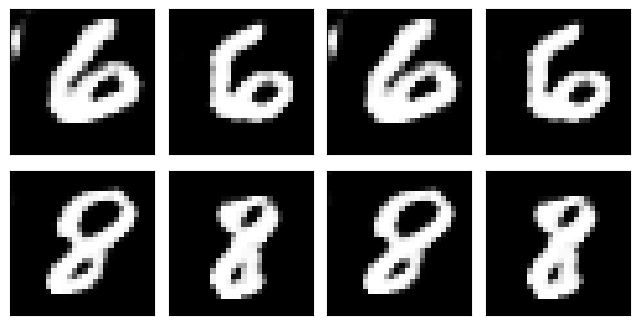

In [3]:
from keras.saving import load_model as load_keras_model
from image_generators.conditional_gan import generate_samples
from image_generators.conditional_gan.default_components import config

generator = load_keras_model('../../image-generation/models/mnist_gan_generator.keras') 

sixes = generate_samples(generator, config, label=6, sample_count=4, verbose=0)
eights = generate_samples(generator, config, label=8, sample_count=4, verbose=0)

fig, axs = plt.subplots(2, 4, figsize=(8, 4))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.setp(axs, xticks=[], yticks=[], xlabel='', ylabel='', aspect='equal')
axs[0, 0].imshow(sixes[0], cmap='gray', vmin=0, vmax=1)
axs[0, 1].imshow(sixes[1], cmap='gray', vmin=0, vmax=1)
axs[0, 2].imshow(sixes[0], cmap='gray', vmin=0, vmax=1)
axs[0, 3].imshow(sixes[1], cmap='gray', vmin=0, vmax=1)
axs[1, 0].imshow(eights[0], cmap='gray', vmin=0, vmax=1)
axs[1, 1].imshow(eights[1], cmap='gray', vmin=0, vmax=1)
axs[1, 2].imshow(eights[0], cmap='gray', vmin=0, vmax=1)
axs[1, 3].imshow(eights[1], cmap='gray', vmin=0, vmax=1)
plt.show()

For conveniance, we use a helper function that allows us to generate $2n$ samples with equal proportions for both classes.  

In [4]:
from model_library.data_loaders import generate_image_pairs
display_source(generate_image_pairs)

```python
def generate_image_pairs(n: int, generator: keras.Model, config,
                         class_0: int, class_1: int, verbose: int = 0) -> Tuple[tf.Tensor, tf.Tensor]:
    """
    Generates n samples of digits for both classes separately, i.e., the outcome contains 2 * n samples.
    Final labels will be zero and one instead of original class labels defined as arguments.
    """
    images = tf.reshape(tf.stack([
        generate_samples(generator, config, label=class_0, sample_count=n, verbose=verbose),
        generate_samples(generator, config, label=class_1, sample_count=n, verbose=verbose)
    ], axis=1), (-1, 28, 28))
    labels = tf.tile(tf.constant([0, 1], 'int32'), (n,))

    return images, labels

```

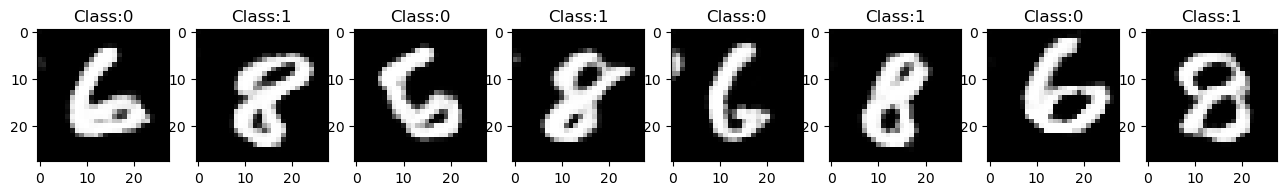

In [5]:
images, labels = generate_image_pairs(4, generator, config, 6, 8)
fig, axs = plt.subplots(1, 8, figsize=(16, 4))
for i in range(0, 8): 
    axs[i].imshow(images[i], cmap='gray', vmin=0, vmax=1)
    axs[i].set_title(f'Class:{labels[i]}')

## II. Model training

From the previous notebook [01_scaling_laws_on_minst_data.ipynb](./01_scaling_laws_on_minst_data.ipynb) we know that logistic regression models perform well on test set consisting of these two numbers. In the following we are going to use all training samples to train the best model and observe hw well it performes on the test set that contains sizable portion of zeroes. Recall that the model should still predict whether the number is eight or not.    

In [6]:
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

training_data = dict()
n_max = min(min(sum(train_labels == 6), sum(train_labels == 8)), 5850)
training_data['6'] = tf.random.shuffle(train_images[train_labels == 6]/255.0)[:n_max]
training_data['8'] = tf.random.shuffle(train_images[train_labels == 8]/255.0)[:n_max]
assert(len(training_data['6']) == len(training_data['8']))

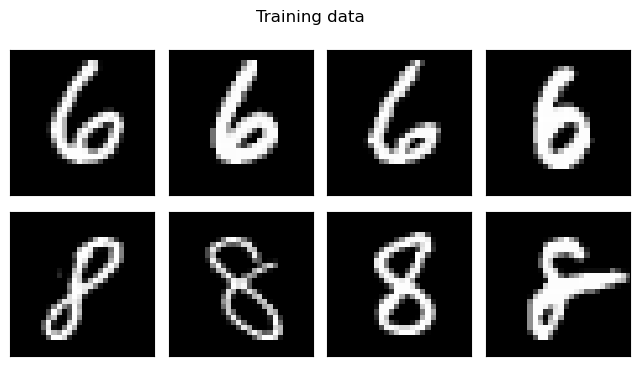

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(8, 4))
plt.suptitle('Training data')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.setp(axs, xticks=[], yticks=[], xlabel='', ylabel='', aspect='equal')
for i in range(4):
    axs[0, i].imshow(training_data['6'][i], cmap='gray', vmin=0, vmax=1)
    axs[1, i].imshow(training_data['8'][i], cmap='gray', vmin=0, vmax=1)
plt.show()

In [8]:
from model_library.logreg import mnist_logreg_model
logreg = mnist_logreg_model()
logreg.summary()
adam_lr = Adam(learning_rate=1e-3)
logreg.compile(optimizer=adam_lr, loss='binary_crossentropy', metrics=['accuracy'])

Model: "Logistic_regression"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           785 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 785 (3.07 KB)

 Trainable params: 785 (3.07 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from model_library.data_loaders import get_image_pairs
from model_library.model_training import train_binary_classifier

N = 5850
model = mnist_logreg_model()
adam_lr = Adam(learning_rate=1e-3)
model.compile(optimizer=adam_lr, loss='binary_crossentropy', metrics=['accuracy'])
images, labels = get_image_pairs(N, training_data, '6', '8')
model, _ = train_binary_classifier(model, images, labels , epochs=100, batch_size=32, collect_telemetry=False)

Epoch Progress:   0%|          | 0/100 [00:00<?, ?epoch/s]

## III. Performance on different data distribution

In the following we are looking at three most typical precision-recall curves and show how to interpret them.  


### Near perfect performance

If we add relatively few zeroes besides equal amount of sixes and eights the line is initailly almost constantly 100% and then drops at the end. 

141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Model accuracy is 94.7%


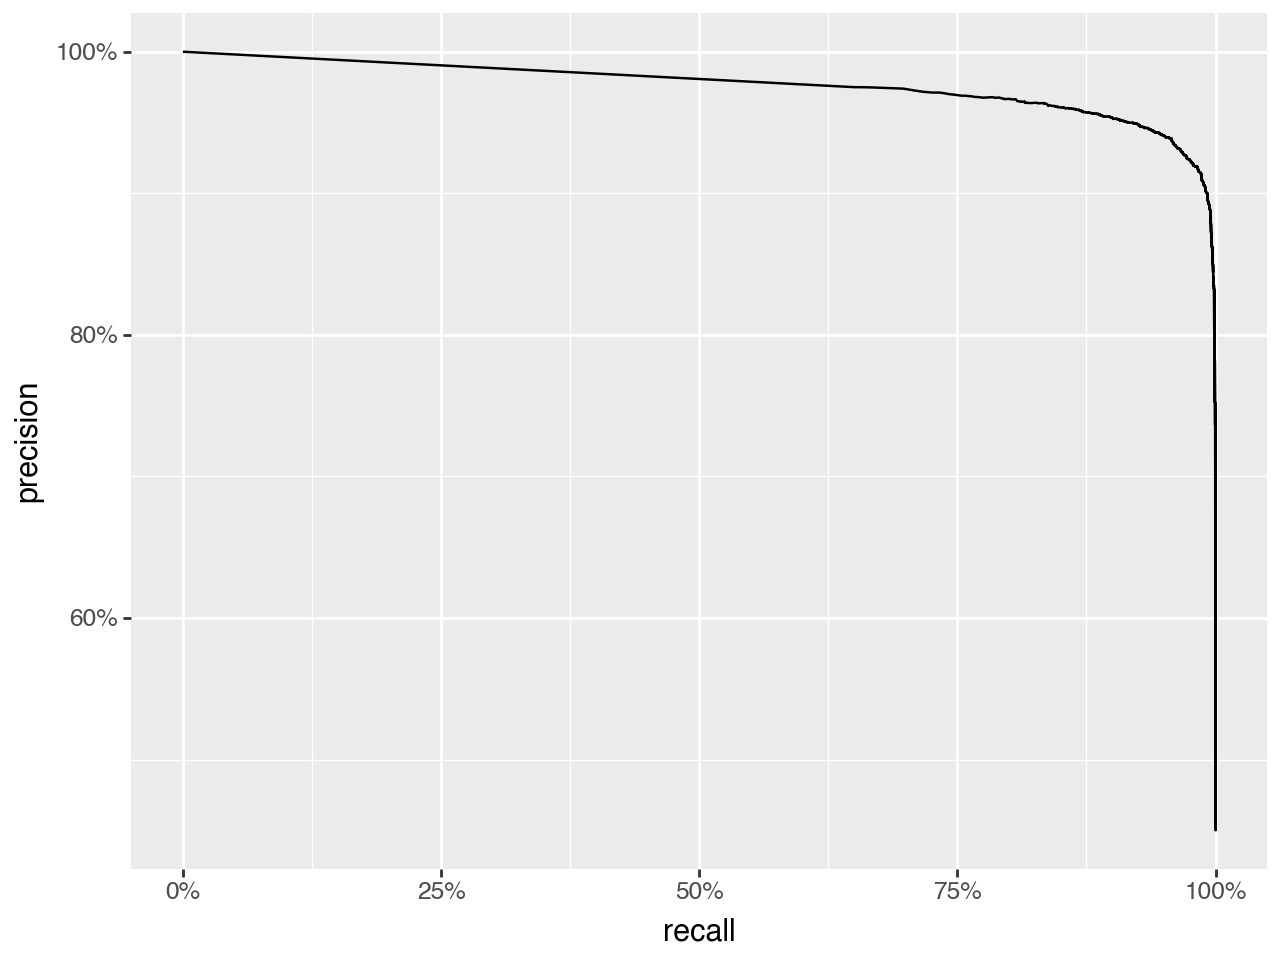

In [10]:
N = 10000
N1 = int(0.45 * N)
N2 = int(0.45 * N)
N3 = N - N1 - N2

test_images = tf.concat([
    generate_samples(generator, config, label=6, sample_count=N1, verbose=1),
    generate_samples(generator, config, label=8, sample_count=N2, verbose=1),
    generate_samples(generator, config, label=0, sample_count=N3, verbose=1)], axis=0)

test_labels = tf.concat([
    tf.constant(0, shape=[N1]),
    tf.constant(1, shape=[N2]),
    tf.constant(0, shape=[N3])], axis=0)

print(f'Model accuracy is {model.evaluate(test_images, test_labels, verbose=0)[1] * 100:2.1f}%')

y_score = tf.squeeze(model.predict(test_images, verbose=0))
precision, recall, _ = precision_recall_curve(y_true=test_labels, y_score=y_score)
pr_curve = pd.DataFrame({'precison': precision, 'recall': recall})

p  = ggplot(pr_curve) 
p += geom_line(aes(x='recall', y='precision'))
p += scale_x_continuous(labels=lambda l: ['{:.0f}%'.format(v * 100) for v in l])
p += scale_y_continuous(labels=lambda l: ['{:.0f}%'.format(v * 100) for v in l])
p
# p.save('../../results/precision_recall_1.pdf', width=6, height=4, units='in')

**What to observe** 
* The model scores instances reliably only reletively small proportion of positive class labels get really low scores.
* There are no sytematic blindspots for the model.

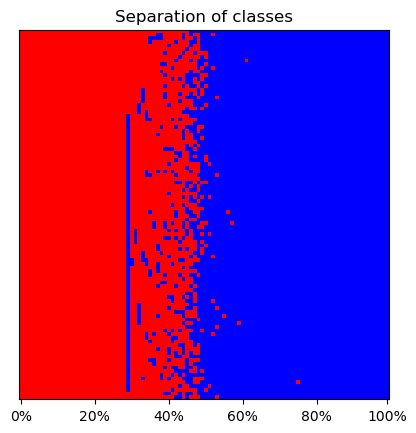

In [11]:
ordered_labels = tf.gather(test_labels, tf.argsort(y_score, direction='DESCENDING'))
label_image =tf.transpose(tf.reshape(ordered_labels, [100, -1]))
plt.title('Separation of classes')
plt.imshow(label_image, cmap= mcolors.ListedColormap(['blue', 'red']))
plt.xticks(ticks=list(range(0, 100, 20)) +[99], labels=[f'{i}%' for i in range(0, 101, 20)])
plt.yticks([])
# plt.savefig('../../results/pr_lable_separation_1.png', format='png')
plt.show()


### Quick linear drop-off at the beginning

By adding a signifficant proportion nines we get a linear drop-off at the beginning. 

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
Model accuracy is 60.3%


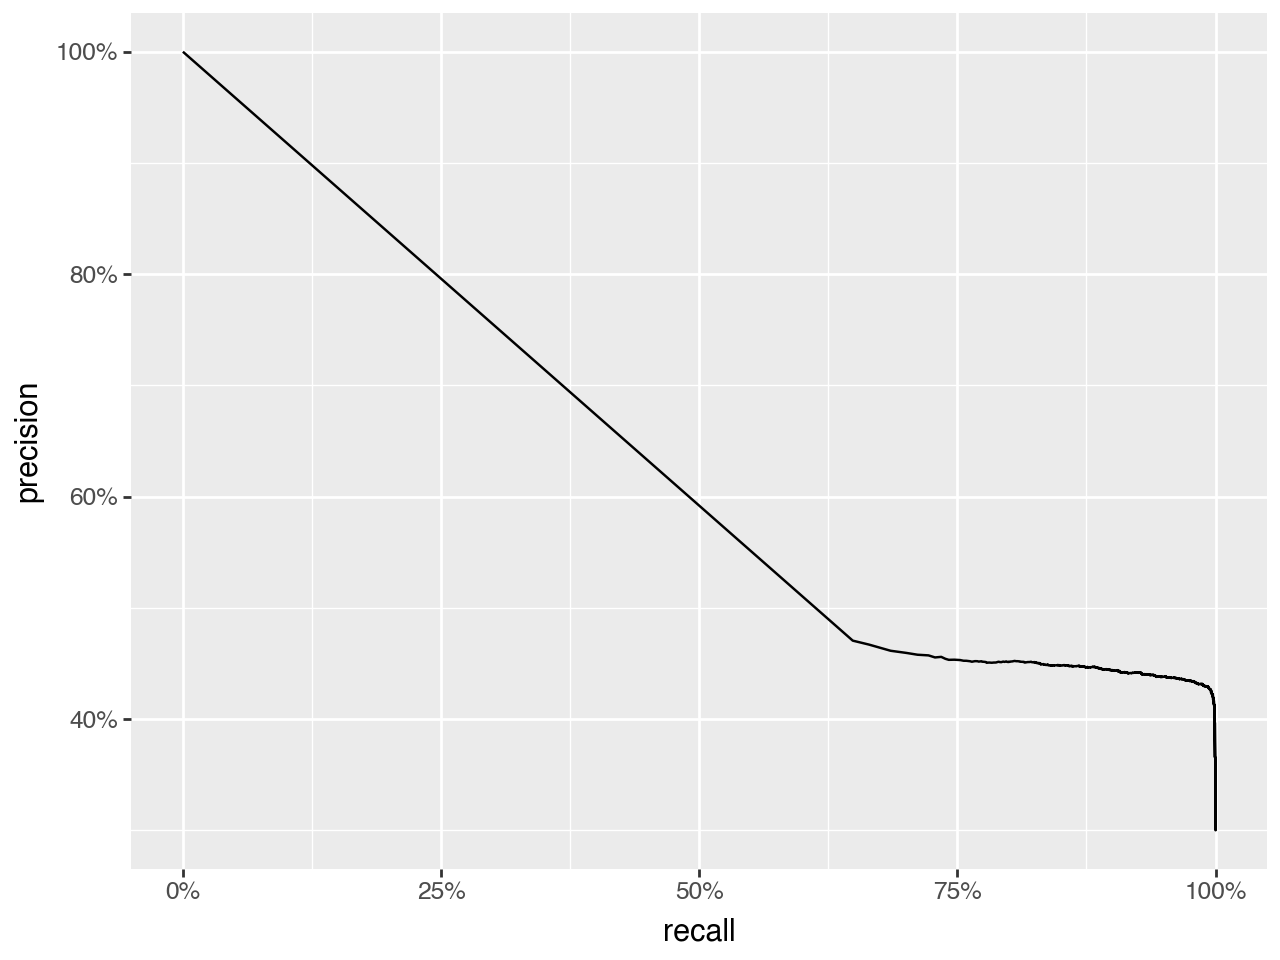

In [12]:
N = 10000
N1 = int(0.3 * N)
N2 = int(0.3 * N)
N3 = N - N1 - N2

test_images = tf.concat([
    generate_samples(generator, config, label=6, sample_count=N1, verbose=1),
    generate_samples(generator, config, label=8, sample_count=N2, verbose=1),
    generate_samples(generator, config, label=9, sample_count=N3, verbose=1)], axis=0)

test_labels = tf.concat([
    tf.constant(0, shape=[N1]),
    tf.constant(1, shape=[N2]),
    tf.constant(0, shape=[N3])], axis=0)

print(f'Model accuracy is {model.evaluate(test_images, test_labels, verbose=0)[1] * 100:2.1f}%')

y_score = tf.squeeze(model.predict(test_images, verbose=0))
precision, recall, _ = precision_recall_curve(y_true=test_labels, y_score=y_score)
pr_curve = pd.DataFrame({'precison': precision, 'recall': recall})

p  = ggplot(pr_curve) 
p += geom_line(aes(x='recall', y='precision'))
p += scale_x_continuous(labels=lambda l: ['{:.0f}%'.format(v * 100) for v in l])
p += scale_y_continuous(labels=lambda l: ['{:.0f}%'.format(v * 100) for v in l])
p
# p.save('../../results/precision_recall_2.pdf', width=6, height=4, units='in')

**What to observe:** 
* A large block of negative instances must get scores that are higher than most of positive labels.
* Stabilisation afterwards means that there composition of positives and negatives becomes uniform again.

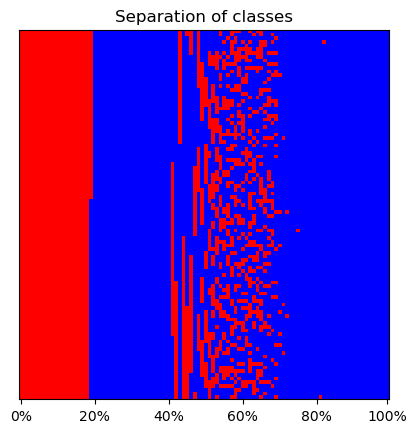

In [13]:
ordered_labels = tf.gather(test_labels, tf.argsort(y_score, direction='DESCENDING'))
label_image =tf.transpose(tf.reshape(ordered_labels, [100, -1]))
plt.title('Separation of classes')
plt.imshow(label_image, cmap= mcolors.ListedColormap(['blue', 'red']))
plt.xticks(ticks=list(range(0, 100, 20)) +[99], labels=[f'{i}%' for i in range(0, 101, 20)])
plt.yticks([])
# plt.savefig('../../results/pr_lable_separation_2.png', format='png')
plt.show()

### Continious slope without stabilisation

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step
Model accuracy is 79.7%


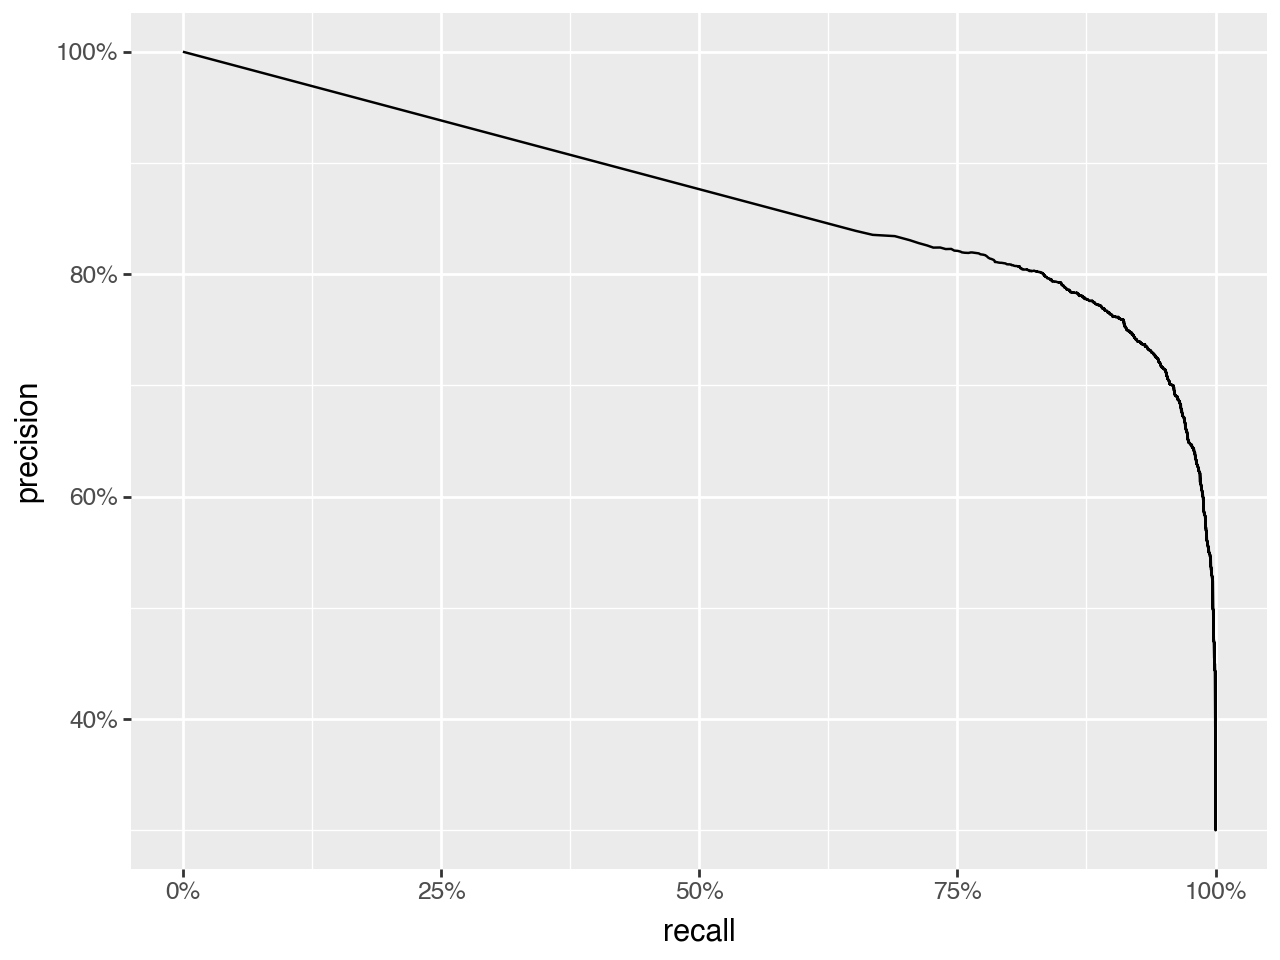

In [14]:
N = 10000
N1 = int(0.3 * N)
N2 = int(0.3 * N)
N3 = N - N1 - N2

test_images = tf.concat([
    generate_samples(generator, config, label=6, sample_count=N1, verbose=1),
    generate_samples(generator, config, label=8, sample_count=N2, verbose=1),
    generate_samples(generator, config, label=0, sample_count=N3, verbose=1)], axis=0)

test_labels = tf.concat([
    tf.constant(0, shape=[N1]),
    tf.constant(1, shape=[N2]),
    tf.constant(0, shape=[N3])], axis=0)

print(f'Model accuracy is {model.evaluate(test_images, test_labels, verbose=0)[1] * 100:2.1f}%')

y_score = tf.squeeze(model.predict(test_images, verbose=0))
precision, recall, _ = precision_recall_curve(y_true=test_labels, y_score=y_score)
pr_curve = pd.DataFrame({'precison': precision, 'recall': recall})

p  = ggplot(pr_curve) 
p += geom_line(aes(x='recall', y='precision'))
p += scale_x_continuous(labels=lambda l: ['{:.0f}%'.format(v * 100) for v in l])
p += scale_y_continuous(labels=lambda l: ['{:.0f}%'.format(v * 100) for v in l])
# p.save('../../results/precision_recall_3.pdf', width=6, height=4, units='in')
p

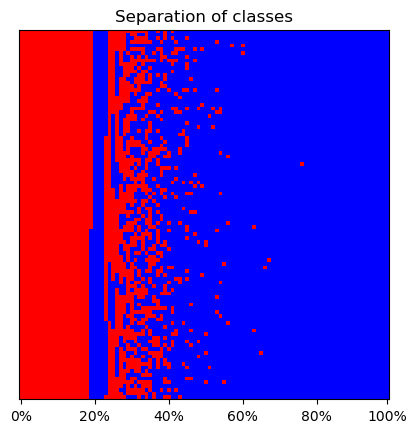

In [15]:
ordered_labels = tf.gather(test_labels, tf.argsort(y_score, direction='DESCENDING'))
label_image =tf.transpose(tf.reshape(ordered_labels, [100, -1]))
plt.title('Separation of classes')
plt.imshow(label_image, cmap= mcolors.ListedColormap(['blue', 'red']))
plt.xticks(ticks=list(range(0, 100, 20)) +[99], labels=[f'{i}%' for i in range(0, 101, 20)])
plt.yticks([])
# plt.savefig('../../results/pr_lable_separation_3.png', format='png')
plt.show()